In [1]:
!pip install -q pyspark

In [2]:
from pyspark.sql import SparkSession

#Crear sesión
spark = SparkSession.builder.appName("ProyectoMetroRegresionLineal").master("local[*]").config("spark.sql.session.timeZone","America/Santiago").getOrCreate()

print("App Nombre: ",spark.sparkContext.appName)

App Nombre:  ProyectoMetroRegresionLineal


In [3]:
# Carga de datos en un DF de Spark

ruta_datos = "metro_santiago_200.csv"

df = (
    spark.read.option("header", True).
    option("inferSchema", True).
    csv(ruta_datos)
)

# Pequeña prueba para ver si los datos se cargaron en el DF
df.printSchema()

root
 |-- id_evento: integer (nullable = true)
 |-- linea: string (nullable = true)
 |-- estacion: string (nullable = true)
 |-- tipo_incidente: string (nullable = true)
 |-- duracion_minutos: integer (nullable = true)
 |-- hora: timestamp (nullable = true)



In [4]:
# Exploración breve del DF

from pyspark.sql import functions as F

# Filas y Columnas
print("Filas: ",df.count(), "| Columnas: ",len(df.columns))

Filas:  200 | Columnas:  6


In [5]:
#Conteo nulos
nulos = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
nulos.show()

+---------+-----+--------+--------------+----------------+----+
|id_evento|linea|estacion|tipo_incidente|duracion_minutos|hora|
+---------+-----+--------+--------------+----------------+----+
|        0|    0|       0|             0|               0|   0|
+---------+-----+--------+--------------+----------------+----+



# Actividad tratado de la info. Con Pipeline 01-09-2025

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, SQLTransformer
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

# 1) Derivar (extraer) la hora dentro del pipeline

hora_sql = SQLTransformer(statement="""
  SELECT *, HOUR(hora) AS hora_num FROM __THIS__
""")

# 2) Indexar categoricos

idx_linea = StringIndexer(inputCol="linea", outputCol="linea_index", handleInvalid="keep")
idx_estacion = StringIndexer(inputCol="estacion", outputCol="estacion_index", handleInvalid="keep")
idx_tipo = StringIndexer(inputCol="tipo_incidente", outputCol="tipo_index", handleInvalid="keep")

# 3) Utilizar OneHotEncoder para preprocesar los categóricos

ohe = OneHotEncoder(inputCols=[idx_linea.getOutputCol(), idx_estacion.getOutputCol(), idx_tipo.getOutputCol()],
                    outputCols=["linea_ohe", "estacion_ohe", "tipo_ohe"],
                    handleInvalid="keep")

# 4) Ensamblar y crear el campo "features"

assembler = VectorAssembler(inputCols=["linea_ohe", "estacion_ohe", "tipo_ohe"], outputCol="features")

# 5) Crear modelo de ML = Regresion Lineal

lr = LinearRegression(featuresCol="features", labelCol="label")

# 6) Creación del pipeline

pipeline = Pipeline(stages=[hora_sql, idx_linea, idx_estacion, idx_tipo, ohe, assembler, lr])

In [12]:
# Tratamiento del target [y] = label

from pyspark.sql import functions as F

# 1) Asegurarme que el campo "hora" sea timestamp
df = df.withColumn("hora", F.to_timestamp("hora"))

# 2) Definir columna objetivo (MLlib) - renombrar

df_ml = df.withColumnRenamed("duracion_minutos", "label")

# 3) Dividir el dataset en entrenamiento/prueba
train_df, test_df = df_ml.randomSplit([0.7,0.3], seed=42)

print("Registros totales: ", df_ml.count())
print("Registros entrenamiento: ", train_df.count())
print("Registros prueba: ", test_df.count())

Registros totales:  200
Registros entrenamiento:  145
Registros prueba:  55


In [13]:
# Entrenar ML
from pyspark.ml.evaluation import RegressionEvaluator

# 4) Entrenar el modelo
pipelineEntrenado = pipeline.fit(train_df)

# 2) Predicciones en el conjunto de prueba
preds = pipelineEntrenado.transform(test_df)

# 3) Métricas de evaluación
rmse = RegressionEvaluator(metricName = "rmse", labelCol= "label", predictionCol="prediction").evaluate(preds)
r2 = RegressionEvaluator(metricName = "r2", labelCol= "label", predictionCol="prediction").evaluate(preds)

print(f"RMSE = {rmse:.2f}")
print(f"R2 = {r2:.2f}")

RMSE = 6.54
R2 = -0.28
+------------------+-----+
|        prediction|label|
+------------------+-----+
|27.846107922754676|   10|
|22.806726274901614|   20|
| 21.77001177212733|   15|
|17.853724331355835|   20|
|23.777731259029828|   25|
| 20.91315543827809|   15|
|23.622305449009236|   20|
|24.044594971436442|   20|
|20.857454369923836|   25|
|23.386416248674504|   30|
|17.559089205214804|   15|
| 23.81482238342134|   25|
|20.874294009405684|   30|
|  20.6329567385502|   15|
| 18.95993226867232|   25|
|22.534819220835175|   30|
|23.521672515916148|   20|
|25.682496292803684|   25|
|21.285552877917713|   20|
| 21.80610902228316|   25|
+------------------+-----+
only showing top 20 rows



In [14]:
preds.select("linea","estacion","tipo_incidente","hora","label","prediction").show(10, truncate=False)

+-----+--------------+------------------------+-------------------+-----+------------------+
|linea|estacion      |tipo_incidente          |hora               |label|prediction        |
+-----+--------------+------------------------+-------------------+-----+------------------+
|L3   |Plaza de Armas|Evacuación              |2025-09-01 14:45:00|10   |27.846107922754676|
|L4A  |Ñuñoa         |Mantenimiento           |2025-09-01 06:45:00|20   |22.806726274901614|
|L2   |Franklin      |Evacuación              |2025-09-01 13:30:00|15   |21.77001177212733 |
|L3   |Irarrázaval   |Interrupción de servicio|2025-09-01 20:00:00|20   |17.853724331355835|
|L1   |Plaza Egaña   |Evacuación              |2025-09-01 19:30:00|25   |23.777731259029828|
|L2   |Los Dominicos |Mantenimiento           |2025-09-01 05:45:00|15   |20.91315543827809 |
|L3   |Vicente Valdés|Falla eléctrica         |2025-09-01 21:15:00|20   |23.622305449009236|
|L1   |Santa Ana     |Falla eléctrica         |2025-09-01 16:15:00|20 

## Creación del otro modelo - Árbol de Regresión MLA

In [19]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# 1) Preprocesamiento de nuevo para este modelo de arbol de regresión
hora_sql_tree = SQLTransformer(statement="""
  SELECT *, HOUR(hora) AS hora_num_feat FROM __THIS__
""")

# 2) Indexar categoricos

idx_linea_tree = StringIndexer(inputCol="linea", outputCol="linea_index", handleInvalid="keep")
idx_estacion_tree = StringIndexer(inputCol="estacion", outputCol="estacion_index", handleInvalid="keep")
idx_tipo_tree = StringIndexer(inputCol="tipo_incidente", outputCol="tipo_index", handleInvalid="keep")

ohe_tree = OneHotEncoder(inputCols=[idx_linea_tree.getOutputCol(), idx_estacion_tree.getOutputCol(), idx_tipo_tree.getOutputCol()],
                         outputCols=["linea_vec","estacion_vec","tipo_vec"],
                         handleInvalid="keep")

assembler_tree = VectorAssembler(
    inputCols=["linea_vec","estacion_vec","tipo_vec","hora_num_feat"],
    outputCol="features"
)

dtr = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="label",
    maxDepth=6,
    minInstancesPerNode=2
)

pipeline_tree = Pipeline(stages=[hora_sql_tree, idx_linea_tree, idx_estacion_tree, idx_tipo_tree, ohe_tree, assembler_tree, dtr])

# Entrenamiento y predicción
dtr_entrenado = pipeline_tree.fit(train_df)
preds_tree = dtr_entrenado.transform(test_df)

# Métricas de evaluación
dtr_rmse = RegressionEvaluator(metricName = "rmse", labelCol= "label", predictionCol="prediction").evaluate(preds_tree)
dtr_mae = RegressionEvaluator(metricName = "mae", labelCol= "label", predictionCol="prediction").evaluate(preds_tree)
dtr_r2 = RegressionEvaluator(metricName = "r2", labelCol= "label", predictionCol="prediction").evaluate(preds_tree)

print(f"RMSE = {dtr_rmse:.2f}")
print(f"MAE = {dtr_mae:.2f}")
print(f"R2 = {dtr_r2:.2f}")

RMSE = 6.28
MAE = 5.10
R2 = -0.18


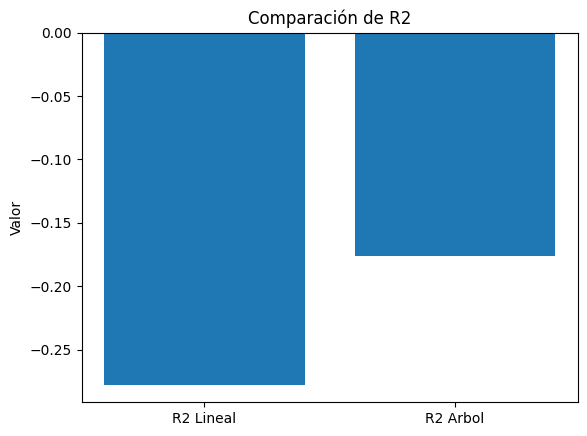

In [22]:
import matplotlib.pyplot as plt

metricas = ["R2 Lineal", "R2 Arbol"]
valores = [r2, dtr_r2]

plt.bar(metricas, valores)
plt.ylabel("Valor")
plt.title("Comparación de R2")
plt.show()

#### Al comparar ambos $r^2$, ninguno de los dos es significativo para el análisis, ya que son negativos, es mejor ajustar los datos de otra manera

In [23]:
preds.select("linea","estacion","tipo_incidente","hora","label","prediction").show(10, truncate=False)
preds_tree.select("linea","estacion","tipo_incidente","hora","label","prediction").show(10, truncate=False)

+-----+--------------+------------------------+-------------------+-----+------------------+
|linea|estacion      |tipo_incidente          |hora               |label|prediction        |
+-----+--------------+------------------------+-------------------+-----+------------------+
|L3   |Plaza de Armas|Evacuación              |2025-09-01 14:45:00|10   |27.846107922754676|
|L4A  |Ñuñoa         |Mantenimiento           |2025-09-01 06:45:00|20   |22.806726274901614|
|L2   |Franklin      |Evacuación              |2025-09-01 13:30:00|15   |21.77001177212733 |
|L3   |Irarrázaval   |Interrupción de servicio|2025-09-01 20:00:00|20   |17.853724331355835|
|L1   |Plaza Egaña   |Evacuación              |2025-09-01 19:30:00|25   |23.777731259029828|
|L2   |Los Dominicos |Mantenimiento           |2025-09-01 05:45:00|15   |20.91315543827809 |
|L3   |Vicente Valdés|Falla eléctrica         |2025-09-01 21:15:00|20   |23.622305449009236|
|L1   |Santa Ana     |Falla eléctrica         |2025-09-01 16:15:00|20 

In [41]:
df_duracion = df.select("duracion_minutos").toPandas()
df_duracion

,duracion_minutos
0,20
1,15
2,10
3,25
4,30
...,...
195,30
196,20
197,15
198,25


Text(0, 0.5, 'Prediction')

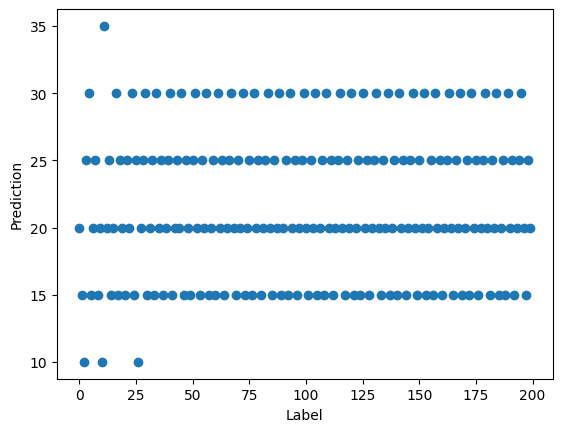

In [43]:
plt.scatter(range(len(df_duracion)),df_duracion["duracion_minutos"])
plt.xlabel("Label")
plt.ylabel("Prediction")

#### Acá se ve claramente que los datos al no ser continuos, no tienen una forma determinada de distribución, de hecho no se ajusta a ninguna distribución conocida a simple vista